## Image Retrieval using AlexNet 

Goals :
- Create AlexNet architecture using Pre-Trained Weights
- Create Image Embeddings using Transfer Learning 
- Create Nearest Neighbour Algorithm 
- Give a query iamges, retrieve similar images 

In [1]:
import tensorflow as tf
import numpy as np
import os
import os.path as op
import random
from scipy import ndimage
from glob import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

%matplotlib inline
print('Tensorflow version : {0}'.format(tf.__version__))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Tensorflow version : 1.13.2


#### AlexNet Architecture

![AlexNet](./images/alexnet_architecture.png)

 Weights from Michael Guerzhoy and Davi Frossard
 [http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/]

### Import Pre-Trained Variables

In [2]:
# Path to the numpy weights
alexnet_path = op.join(op.curdir, 'processed','bvlc_alexnet.npy')

In [3]:
# read weights in numpy
variable_data = np.load(alexnet_path, encoding='bytes',allow_pickle=True).item()

In [4]:
# variable_data is a dictionary
type(variable_data)

dict

In [5]:
# keys
variable_data.keys()

dict_keys(['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4'])

In [6]:
# Convolution layer - 1 weights
conv1_preW = variable_data["conv1"][0]
conv1_preb = variable_data["conv1"][1]
print(conv1_preW.shape)
print(conv1_preb.shape)

(11, 11, 3, 96)
(96,)


In [7]:
# Convolution layer - 2 weights
conv2_preW = variable_data["conv2"][0]
conv2_preb = variable_data["conv2"][1]
print(conv2_preW.shape)
print(conv2_preb.shape)

(5, 5, 48, 256)
(256,)


In [8]:
# Convolution layer-3 weights
conv3_preW = variable_data["conv3"][0]
conv3_preb = variable_data["conv3"][1]
print(conv3_preW.shape)
print(conv3_preb.shape)

(3, 3, 256, 384)
(384,)


In [9]:
# Convolution layer-4 weights
conv4_preW = variable_data["conv4"][0]
conv4_preb = variable_data["conv4"][1]
print(conv4_preW.shape)
print(conv4_preb.shape)

(3, 3, 192, 384)
(384,)


In [10]:
# Convolution layer-5 weights
conv5_preW = variable_data["conv5"][0]
conv5_preb = variable_data["conv5"][1]
print(conv5_preW.shape)
print(conv5_preb.shape)

(3, 3, 192, 256)
(256,)


In [11]:
# Fully contected layer - 1
fc6_preW = variable_data["fc6"][0]
fc6_preb = variable_data["fc6"][1]
print(fc6_preW.shape)
print(fc6_preb.shape)

(9216, 4096)
(4096,)


In [12]:
# Fully connected layer -2 
fc7_preW = variable_data["fc7"][0]
fc7_preb = variable_data["fc7"][1]
print(fc7_preW.shape)
print(fc7_preb.shape)

(4096, 4096)
(4096,)


In [13]:
# Fully connected layer - 3
fc8_preW = variable_data["fc8"][0]
fc8_preb = variable_data["fc8"][1]
print(fc8_preW.shape)
print(fc8_preb.shape)

(4096, 1000)
(1000,)


### Create the AlexNet Network

In [14]:
pixel_depth = 255.0
resized_height = 227
resized_width = 227
num_channels = 3

graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.uint8, [None, None, None, num_channels],
                       name='input')
    
    to_float = tf.cast(x, tf.float32)
    resized = tf.image.resize_images(to_float, (resized_height, resized_width))
    
    # Convolution 1
    with tf.name_scope('conv1') as scope:
        kernel = tf.Variable(conv1_preW, name='weights')
        biases = tf.Variable(conv1_preb, name='biases')
        conv = tf.nn.conv2d(resized, kernel, [1, 4, 4, 1], padding="SAME")
        bias = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(bias, name=scope)

    # Local response normalization 2
    radius = 2
    alpha = 2e-05
    beta = 0.75
    bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1,
                                              depth_radius=radius,
                                              alpha=alpha,
                                              beta=beta,
                                              bias=bias)

    # Maxpool 1
    pool1 = tf.nn.max_pool(lrn1,
                           ksize=[1, 3, 3, 1],
                           strides=[1, 2, 2, 1],
                           padding='VALID',
                           name='pool1')

    # Convolution 2
    with tf.name_scope('conv2') as scope:

        kernel = tf.Variable(conv2_preW, name='weights')
        biases = tf.Variable(conv2_preb, name='biases')

        input_a, input_b = tf.split(axis=3,
                                    num_or_size_splits=2,
                                    value=pool1)
        kernel_a, kernel_b = tf.split(axis=3,
                                    num_or_size_splits=2,
                                      value=kernel)

        with tf.name_scope('A'):
            conv_a = tf.nn.conv2d(input_a, kernel_a, [1, 1, 1, 1], padding="SAME")        

        with tf.name_scope('B'):
            conv_b = tf.nn.conv2d(input_b, kernel_b, [1, 1, 1, 1], padding="SAME")

        conv = tf.concat(values=[conv_a, conv_b], axis=3)
        bias = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(bias, name=scope)

    # Local response normalization 2
    radius = 2
    alpha = 2e-05
    beta = 0.75
    bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2,
                                              depth_radius=radius,
                                              alpha=alpha,
                                              beta=beta,
                                              bias=bias)

    # Maxpool 2
    pool2 = tf.nn.max_pool(lrn2,
                           ksize=[1, 3, 3, 1],
                           strides=[1, 2, 2, 1],
                           padding='VALID',
                           name='pool2')

    with tf.name_scope('conv3') as scope:
        kernel = tf.Variable(conv3_preW, name='weights')
        biases = tf.Variable(conv3_preb, name='biases')
        conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding="SAME")
        bias = tf.nn.bias_add(conv, biases)
        conv3 = tf.nn.relu(bias, name=scope)


    with tf.name_scope('conv4') as scope:

        kernel = tf.Variable(conv4_preW, name='weights')
        biases = tf.Variable(conv4_preb, name='biases')

        input_a, input_b = tf.split(axis=3,
                                    num_or_size_splits=2,
                                    value=conv3)
        kernel_a, kernel_b = tf.split(axis=3,
                                    num_or_size_splits=2,
                                      value=kernel)

        with tf.name_scope('A'):
            conv_a = tf.nn.conv2d(input_a, kernel_a, [1, 1, 1, 1], padding="SAME")        

        with tf.name_scope('B'):
            conv_b = tf.nn.conv2d(input_b, kernel_b, [1, 1, 1, 1], padding="SAME")

        conv = tf.concat(values=[conv_a, conv_b], axis=3)
        bias = tf.nn.bias_add(conv, biases)
        conv4 = tf.nn.relu(bias, name=scope)


    with tf.name_scope('conv5') as scope:

        kernel = tf.Variable(conv5_preW, name='weights')
        biases = tf.Variable(conv5_preb, name='biases')

        input_a, input_b = tf.split(axis=3,
                                    num_or_size_splits=2,
                                    value=conv4)
        kernel_a, kernel_b = tf.split(axis=3,
                                      num_or_size_splits=2,
                                      value=kernel)

        with tf.name_scope('A'):
            conv_a = tf.nn.conv2d(input_a, kernel_a, [1, 1, 1, 1], padding="SAME")        

        with tf.name_scope('B'):
            conv_b = tf.nn.conv2d(input_b, kernel_b, [1, 1, 1, 1], padding="SAME")

        conv = tf.concat(values=[conv_a, conv_b],axis=3)
        bias = tf.nn.bias_add(conv, biases)
        conv5 = tf.nn.relu(bias, name=scope)


    # Maxpool 2
    pool5 = tf.nn.max_pool(conv5,
                           ksize=[1, 3, 3, 1],
                           strides=[1, 2, 2, 1],
                           padding='VALID',
                           name='pool5')

    # Fully connected 6
    with tf.name_scope('fc6'):
        weights = tf.Variable(fc6_preW, name='fc6_weights')
        bias = tf.Variable(fc6_preb, name='fc6_bias')
        shape = tf.shape(pool5)
        size = shape[1] * shape[2] * shape[3]
        fc6 = tf.nn.relu_layer(tf.reshape(pool5, [-1, size]),
                               weights, bias, name='relu')

    # Fully connected 7
    with tf.name_scope('fc7'):
        weights = tf.Variable(fc7_preW, name='weights')
        bias = tf.Variable(fc7_preb, name='bias')
        fc7 = tf.nn.relu_layer(fc6, weights, bias, name='relu')

    # Fully connected 8
    with tf.name_scope('fc8'):
        weights = tf.Variable(fc8_preW, name='weights')
        bias = tf.Variable(fc8_preb, name='bias')
        # fc8 = tf.matmul(fc7, weights) + bias
        fc8 = tf.nn.xw_plus_b(fc7, weights, bias)

    softmax = tf.nn.softmax(fc8)

    init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# visualize alexnet graph
sess = tf.Session(graph=graph)
sess.run(init)

writer = tf.summary.FileWriter('tensorboard/alexnet', graph=graph)
writer.close()

In [16]:
#!tensorboard --logdir='tensorboard/alexnet'

### Export AlexNet Model ( Graph + Weights )

In [17]:
with graph.as_default():
    saver = tf.train.Saver()
    alex_vars_path = op.join(op.curdir, 'saved_models','alex_vars')
    save_path = saver.save(sess, alex_vars_path)

## Import Graph and Weights

In [18]:
alex_vars_path = op.join(op.curdir, 'saved_models','alex_vars')
alex_meta_file_path = op.join(op.curdir, 'saved_models','alex_vars.meta')
graph = tf.Graph()
with graph.as_default():    
    importer = tf.train.import_meta_graph(alex_meta_file_path)

sess = tf.Session(graph=graph)
importer.restore(sess, alex_vars_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./saved_models/alex_vars


In [19]:
graph.get_operations()

[<tf.Operation 'input' type=Placeholder>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'resize/size' type=Const>,
 <tf.Operation 'resize/ResizeBilinear' type=ResizeBilinear>,
 <tf.Operation 'conv1/weights/initial_value' type=Const>,
 <tf.Operation 'conv1/weights' type=VariableV2>,
 <tf.Operation 'conv1/weights/Assign' type=Assign>,
 <tf.Operation 'conv1/weights/read' type=Identity>,
 <tf.Operation 'conv1/biases/initial_value' type=Const>,
 <tf.Operation 'conv1/biases' type=VariableV2>,
 <tf.Operation 'conv1/biases/Assign' type=Assign>,
 <tf.Operation 'conv1/biases/read' type=Identity>,
 <tf.Operation 'conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'conv1/BiasAdd' type=BiasAdd>,
 <tf.Operation 'conv1' type=Relu>,
 <tf.Operation 'LRN' type=LRN>,
 <tf.Operation 'pool1' type=MaxPool>,
 <tf.Operation 'conv2/weights/initial_value' type=Const>,
 <tf.Operation 'conv2/weights' type=VariableV2>,
 <tf.Operation 'conv2/weights/Assign' type=Assign>,
 <tf.Operation 'conv2/weights/read' type=Identity

In [20]:
# extract fc7 output
fc7_op = graph.get_operation_by_name('fc7/relu')
fc7 = fc7_op.outputs[0]
x = graph.get_operation_by_name('input').outputs[0]
init = graph.get_operation_by_name('init')

sess = tf.Session(graph=graph)
sess.run(init)

In [21]:
image_embedding_size = fc7.get_shape()[1]
print('Image embedding size : {0}'.format(image_embedding_size))


Image embedding size : 4096


### Perform Image Embedding

In [22]:
# UTZap50K
UTZap50K_directory = op.join(op.curdir, 'processed','utzap50k')

all_files = [y for x in os.walk(UTZap50K_directory) for y in glob(os.path.join(x[0], '*.jpg'))]
len(all_files)

50066

In [23]:
# sample paths
all_files[:5]

['./processed/utzap50k/ut-zap50k-images-square/Shoes/Firstwalker/Timberland Kids/7899439.515.jpg',
 './processed/utzap50k/ut-zap50k-images-square/Shoes/Firstwalker/Ralph Lauren Layette Kids/8025314.5296.jpg',
 './processed/utzap50k/ut-zap50k-images-square/Shoes/Firstwalker/Ralph Lauren Layette Kids/8046222.316408.jpg',
 './processed/utzap50k/ut-zap50k-images-square/Shoes/Firstwalker/Ralph Lauren Layette Kids/8025307.500.jpg',
 './processed/utzap50k/ut-zap50k-images-square/Shoes/Firstwalker/Ralph Lauren Layette Kids/7237295.133239.jpg']

image shape : (136, 136, 3)


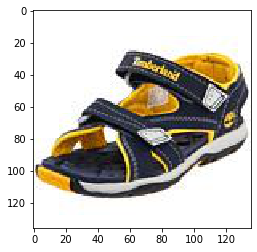

In [24]:
# show a sample image
import imageio
image = imageio.imread(all_files[0])
print('image shape : {0}'.format(image.shape))
plt.imshow(image)
plt.show()

In [25]:
# Number of images to build Nearest Neighbors Model
random.shuffle(all_files)
num_images = 2000 # increase the number of images to increase the image database
neighbor_list = all_files[:num_images]

In [26]:
# create empty array with shape : num_images * image_embedding_size
image_embeddings = np.ndarray((num_images, image_embedding_size))

In [27]:
# create image embedding for each image 
for i, filename in enumerate(neighbor_list):
    image = imageio.imread(filename)
    features = sess.run(fc7, feed_dict={x: [image]})
    image_embeddings[i:i+1] = features
    if i % 250 == 0:
        print(i)

0
250
500
750
1000
1250
1500
1750


In [28]:
# shape of image embeddings
image_embeddings.shape

(2000, 4096)

### Find Similar Images 

In [29]:
g = tf.Graph()
NUM_IMAGES = len(neighbor_list)
EMBEDDING_DIMENSION = 4096

with g.as_default():
    # provide input indices 
    x = tf.placeholder(shape=[None], dtype=tf.int32, name='x')
    
    # create a constant initializer
    weights_initializer = tf.constant_initializer(image_embeddings)
    embedding_weights = tf.get_variable(
                            name='embedding_weights', 
                            shape=(NUM_IMAGES, EMBEDDING_DIMENSION), 
                            initializer=weights_initializer,
                            trainable=False)
    # emebedding Lookup 
    embedding_lookup = tf.nn.embedding_lookup(embedding_weights, x)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding_weights), 1, keepdims=True))
    normalized_embeddings = embedding_weights / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, x)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    

Shape of Similarity Matrix: (10, 2000)


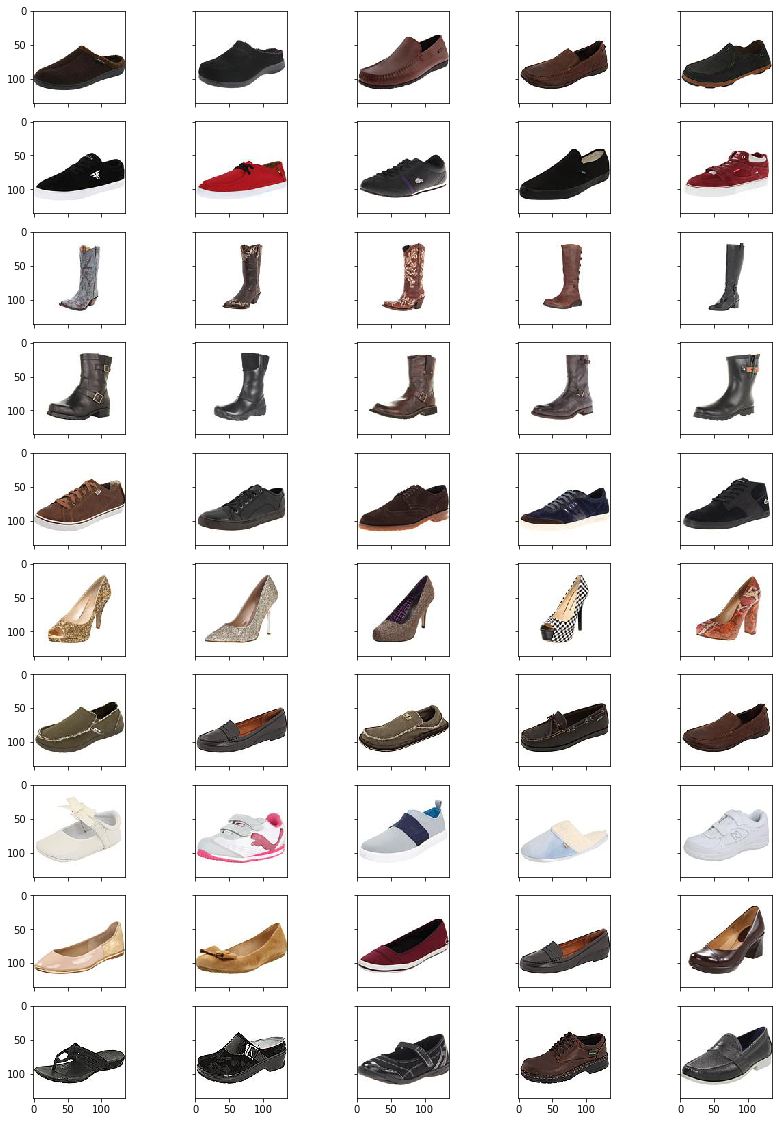

In [30]:
NUM_QUERY_IMAGES = 10
NUM_NEIGHBORS = 5
query_indices = np.random.choice(range(len(neighbor_list)), NUM_QUERY_IMAGES, replace=False)

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    sim = sess.run(similarity, feed_dict={x : query_indices})
    
    f,ax = plt.subplots(NUM_QUERY_IMAGES,NUM_NEIGHBORS, sharex=True, sharey=True, figsize=(14,20))
    
    print('Shape of Similarity Matrix: {0}'.format(sim.shape))
    for i,image_index in enumerate(query_indices):
       
        top_k = NUM_NEIGHBORS # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to {0} :'.format(neighbor_list[image_index])
        
        for k in range(top_k):
            close_image = imageio.imread(neighbor_list[nearest[k]])
            ax[i,k].imshow(close_image)
    plt.show()



## Further Extension

**Approximate Nearest Neighbor Search** 

Currently we are comparing each image with every other image that is not recommended for production scenarios. Use techniques such as Approximate Nearest Neighbor to accelerate the process.

- You can explore ANNOY  package by Spotify [ https://github.com/spotify/annoy ]
- You can also explore LSH ( Locality Senstivity Hashing ) [ https://graphics.stanford.edu/courses/cs468-06-fall/Slides/aneesh-michael.pdf ]